ExactExplainer explainer: 1159it [00:10,  8.70it/s]                           
ExactExplainer explainer: 1159it [03:47,  4.89it/s]                          


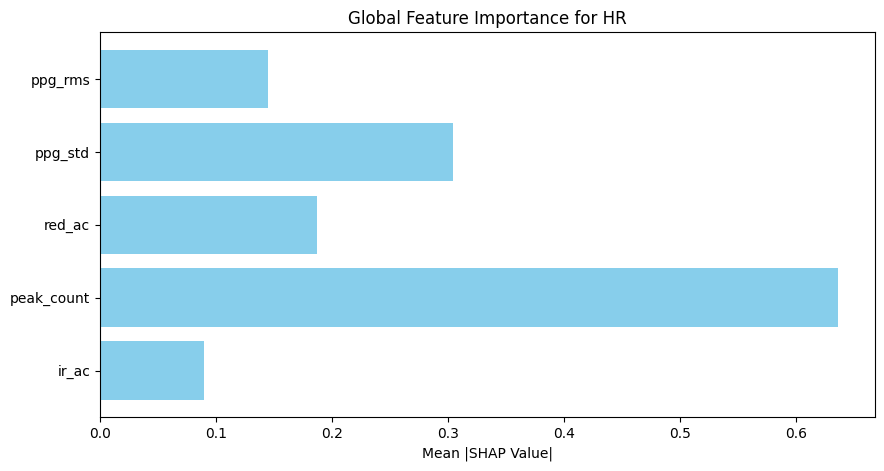

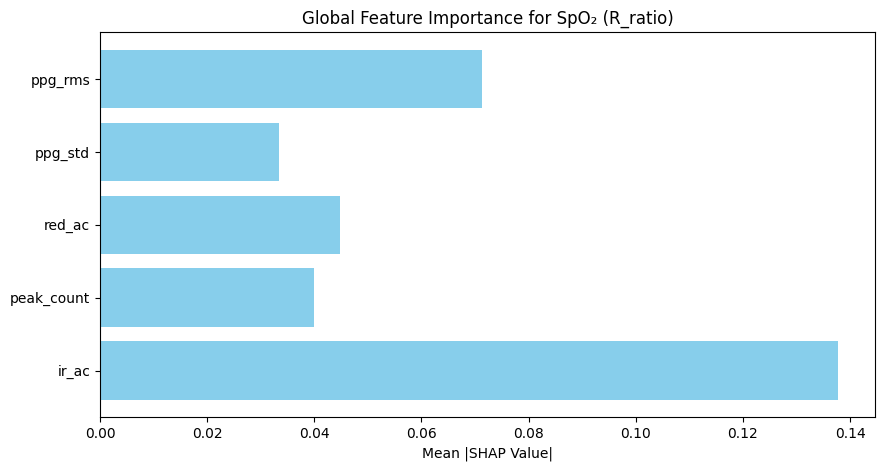

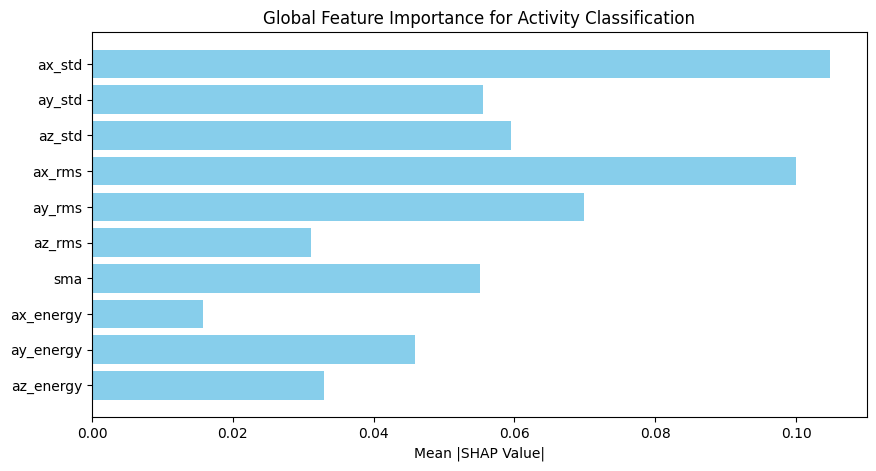

HR: Top features driving predictions: peak_count (SHAP=0.637), ppg_std (SHAP=0.304), red_ac (SHAP=0.187)
SpO₂: Top features driving predictions: ir_ac (SHAP=0.138), ppg_rms (SHAP=0.071), red_ac (SHAP=0.045)
Activity: Top features driving predictions: ax_std (SHAP=0.105), ax_rms (SHAP=0.100), ay_rms (SHAP=0.070)


In [36]:
# ==========================================
# XAI Notebook for Physiological + Activity Prediction
# ==========================================

import os
import numpy as np
import pandas as pd
import joblib
import shap
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import json

# ------------------------
# Load trained models and scalers
# ------------------------
physio_model = load_model("Deep Learning Module/Deep Learning Module/models/physio_mlp_tf")
physio_scaler_X = joblib.load("Deep Learning Module/Deep Learning Module/models/physio_scaler_X_tf.pkl")
physio_scaler_y = joblib.load("Deep Learning Module/Deep Learning Module/models/physio_scaler_y_tf.pkl")
PHYSIO_FEATURES = ['ppg_rms', 'ppg_std', 'red_ac', 'peak_count', 'ir_ac']

activity_model = load_model("Deep Learning Module/Deep Learning Module/models/activity_classification_mlp")
activity_scaler = joblib.load("Deep Learning Module/Deep Learning Module/models/activity_scaler.pkl")
label_encoder = joblib.load("Deep Learning Module/Deep Learning Module/models/activity_label_encoder.pkl")
ACTIVITY_FEATURES = joblib.load("Deep Learning Module/Deep Learning Module/models/activity_features.pkl")

# ------------------------
# Load processed dataset
# ------------------------
DATA_PATH = "Data/processed/fused_ppg_acc_features.csv"
df = pd.read_csv(DATA_PATH).dropna().reset_index(drop=True)

# ------------------------
# Prepare inputs
# ------------------------
X_physio = df[PHYSIO_FEATURES]
y_physio = df[['hr_bpm', 'R_ratio']]

X_activity = df[ACTIVITY_FEATURES]
X_activity_scaled = activity_scaler.transform(X_activity)
X_physio_scaled = physio_scaler_X.transform(X_physio)

# ------------------------
# SHAP Explainers
# ------------------------
explainer_physio = shap.Explainer(physio_model, X_physio_scaled)
shap_physio = explainer_physio(X_physio_scaled)

explainer_activity = shap.Explainer(activity_model, X_activity_scaled)
shap_activity = explainer_activity(X_activity_scaled)

# ------------------------
# Compute global mean absolute SHAP values
# ------------------------
# Physiological
mean_shap_hr = np.mean(np.abs(shap_physio.values[:, :, 0]), axis=0)
mean_shap_spo2 = np.mean(np.abs(shap_physio.values[:, :, 1]), axis=0)

# Activity
# If multi-class, take mean over classes and samples
if len(shap_activity.values.shape) == 3:  # (samples, features, classes)
    mean_shap_activity = np.mean(np.abs(shap_activity.values), axis=(0, 2))
else:
    mean_shap_activity = np.mean(np.abs(shap_activity.values), axis=0)

# ------------------------
# Make JSON serializable
# ------------------------
global_physio = {
    'HR': dict(zip(PHYSIO_FEATURES, mean_shap_hr.tolist())),
    'SpO2_R_ratio': dict(zip(PHYSIO_FEATURES, mean_shap_spo2.tolist()))
}

global_activity = dict(zip(ACTIVITY_FEATURES, mean_shap_activity.tolist()))

global_importance = {
    'physio': global_physio,
    'activity': global_activity
}

os.makedirs("xai", exist_ok=True)
with open("xai/shap_global.json", "w") as f:
    json.dump(global_importance, f, indent=2)

# ------------------------
# Plot Global Feature Importance
# ------------------------
def plot_global_importance(features, values, title):
    plt.figure(figsize=(10,5))
    plt.barh(features, values, color='skyblue')
    plt.xlabel("Mean |SHAP Value|")
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

plot_global_importance(PHYSIO_FEATURES, mean_shap_hr, "Global Feature Importance for HR")
plot_global_importance(PHYSIO_FEATURES, mean_shap_spo2, "Global Feature Importance for SpO₂ (R_ratio)")
plot_global_importance(ACTIVITY_FEATURES, mean_shap_activity, "Global Feature Importance for Activity Classification")

# ------------------------
# Human-readable explanations for top features
# ------------------------
def explain_top_features(features, shap_values, n=3):
    top_idx = np.argsort(np.abs(shap_values))[::-1][:n]
    explanation = "Top features driving predictions: "
    explanation += ", ".join([f"{features[i]} (SHAP={shap_values[i]:.3f})" for i in top_idx])
    return explanation

print("HR:", explain_top_features(PHYSIO_FEATURES, mean_shap_hr))
print("SpO₂:", explain_top_features(PHYSIO_FEATURES, mean_shap_spo2))
print("Activity:", explain_top_features(ACTIVITY_FEATURES, mean_shap_activity))


